In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import warnings
import random
import gc
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error as mse

In [ ]:
df = pd.read_csv('../input/cmsdata/CMS_trigger.csv').drop(columns=['Unnamed: 0'])
df['No. of non-hits'] = df[['Mask_'+str(i) for i in range(12)]].sum(axis = 1)

# Remove particles with number of hits less than 3
df = df[df['No. of non-hits']<9].reset_index(drop=True)

# q is -1 or 1, 1/pT can be obtained by taking its absolute value
df['1/pT'] = df['q/pt'].abs()
df = df.fillna(-100)

In [ ]:
# Shuffle the data frame and split into 10 parts
# Out of those 10 parts 8 will be used for training, 1 for validation and 1 for tesing
shuffled_list = list(range(len(df)))
random.Random(242).shuffle(shuffled_list)
shuffled_list = np.array_split(np.array(shuffled_list), 10)

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df
df = reduce_mem_usage(df)

In [ ]:
# Optimal values obtained by performing Bayesian Hyperparameter optimization
values = [0.27622648017994983, 0.5572619319129042, 0.4093734644841744, 39, 98, 0.7657601467713301, 0.6652163201643659, 76]

In [ ]:
gc.collect()

In [ ]:
OOF_preds = pd.DataFrame()
OOF_preds['row'] = []
OOF_preds['true_value'] = []
OOF_preds['preds'] = []

**Splitted dataframe into 10 parts. Out of those 10 parts 8 are used for training, 1 for validation and 1 for tesing.<br>
This way performing 10 fold cross validation and storing out of fold predictions**

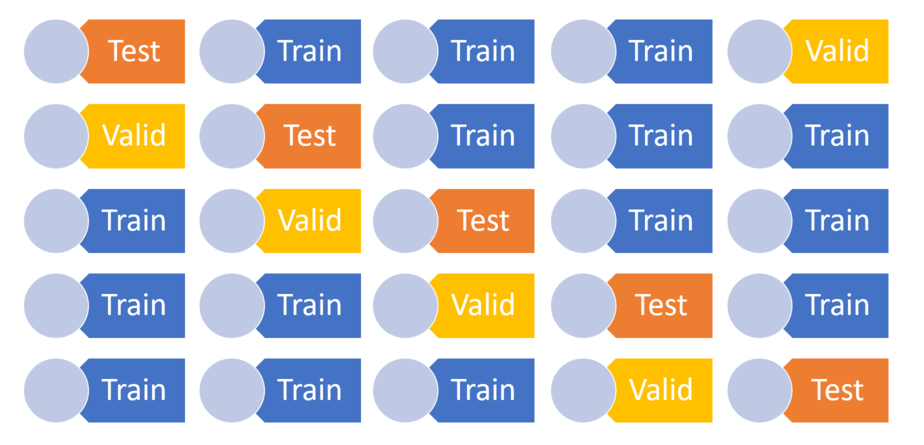

In [ ]:
i=0
for i in range(10):
    train_x = df.iloc[np.concatenate([shuffled_list[j] for j in range(10) if j not in (i, int((i+1)%10))])].drop(columns = ['1/pT','q/pt','PhiAngle', 'EtaAngle'])
    train_y = df['1/pT'].iloc[np.concatenate([shuffled_list[j] for j in range(10) if j not in (i, int((i+1)%10))])]
    valid_x = df.iloc[shuffled_list[i]].drop(columns = ['1/pT','q/pt','PhiAngle', 'EtaAngle'])
    valid_y = df['1/pT'].iloc[shuffled_list[i]]
    test_x = df.iloc[shuffled_list[int((i+1)%10)]].drop(columns = ['1/pT','q/pt','PhiAngle', 'EtaAngle'])
    test_y = df['1/pT'].iloc[shuffled_list[int((i+1)%10)]]

    lgb_dataset = lgb.Dataset(train_x.values, label=train_y)
    lgb_valid_dataset = lgb.Dataset(valid_x.values, label=valid_y)

    lgb_r_params = {
    'objective': 'regression',
    'metric': 'mse',
    'learning_rate': values[0],
    'lambda_l1': values[1],
    'lambda_l2': values[2],
    'max_depth': values[3],
    'min_child_samples': values[4],
    'feature_fraction': values[5],
    'bagging_fraction': values[6],
    'n_estimators' : 20000}

    gbc = lgb.train(lgb_r_params, lgb_dataset, valid_names=["train", "valid"], 
                    valid_sets=[lgb_dataset, lgb_valid_dataset], 
                    early_stopping_rounds=values[7],verbose_eval=50)

    valid_preds = gbc.predict(valid_x.values, num_iteration=gbc.best_iteration)
    valid_mse =  mse(valid_preds, valid_y)

    test_preds = gbc.predict(test_x.values, num_iteration=gbc.best_iteration)
    test_mse =  mse(test_preds, test_y)

    print('Best Iteration - ',gbc.best_iteration, '  |  ','Valid MSE - ',valid_mse, '  |  ', 'Test MSE - ', test_mse)
    print()
    OOF_preds_ = pd.DataFrame()
    OOF_preds_['row'] = shuffled_list[int((i+1)%10)]
    OOF_preds_['true_value'] = test_y.values
    OOF_preds_['preds'] = test_preds
    OOF_preds = pd.concat([OOF_preds,OOF_preds_],axis = 0).reset_index(drop = True)
    gc.collect()
    
OOF_preds = OOF_preds.sort_values(by = 'row').reset_index(drop = True)
OOF_preds.to_csv('OOF_preds.csv')